In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import time 

df = pd.read_pickle('data/pkl/PreciosOF.xlsx.pkl')
df

,Fecha,Compra,Venta
1,2023-02-02,186.14,195.14
2,2023-02-01,185.95,194.95
3,2023-01-31,185.36,194.36
4,2023-01-30,185.07,194.07
5,2023-01-27,184.06,193.06
...,...,...,...
3225,2010-01-07,3.79,3.83
3226,2010-01-06,3.79,3.83
3227,2010-01-05,3.78,3.82
3228,2010-01-04,3.78,3.82


In [42]:
# renaming for fbprophet
df.rename(columns={'Fecha':'ds'}, inplace=True)
df.rename(columns={'Venta':'y'}, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,ds,Compra,y
0,1,2023-02-02,186.14,195.14
1,2,2023-02-01,185.95,194.95
2,3,2023-01-31,185.36,194.36
3,4,2023-01-30,185.07,194.07
4,5,2023-01-27,184.06,193.06


In [43]:
df.rename(columns={'Fecha':'ds'}, inplace=True)

In [44]:
df = df[df['ds'] >= '2018-01-01']

df

,index,ds,Compra,y
0,1,2023-02-02,186.14,195.14
1,2,2023-02-01,185.95,194.95
2,3,2023-01-31,185.36,194.36
3,4,2023-01-30,185.07,194.07
4,5,2023-01-27,184.06,193.06
...,...,...,...,...
1270,1271,2018-01-05,18.86,19.26
1271,1272,2018-01-04,18.56,18.96
1272,1273,2018-01-03,18.38,18.78
1273,1274,2018-01-02,18.36,18.76


In [45]:
df.drop(['Compra'], axis=1)

,index,ds,y
0,1,2023-02-02,195.14
1,2,2023-02-01,194.95
2,3,2023-01-31,194.36
3,4,2023-01-30,194.07
4,5,2023-01-27,193.06
...,...,...,...
1270,1271,2018-01-05,19.26
1271,1272,2018-01-04,18.96
1272,1273,2018-01-03,18.78
1273,1274,2018-01-02,18.76


In [46]:
df = df.sort_values(by='ds')

In [47]:
df['y'].round(2).describe()

count    1275.000000
mean       81.505780
std        42.573478
min        18.760000
25%        43.680000
50%        77.700000
75%       105.850000
max       195.400000
Name: y, dtype: float64

In [48]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(df)

18:58:10 - cmdstanpy - INFO - Chain [1] start processing
18:58:12 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
future_dataset= prophet_model.make_future_dataframe(periods=1, freq='y') # Data para el proximo año
future_dataset.tail()

,ds
1234,2023-01-31
1235,2023-02-01
1236,2023-02-02
1237,2023-02-04
1238,2023-12-31


In [50]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-02,17.888959,16.431325,19.312760
1,2018-01-03,18.015361,16.627366,19.402491
2,2018-01-04,18.205777,16.779083,19.617301
3,2018-01-05,18.338336,16.962233,19.708110
4,2018-01-08,18.667709,17.267451,20.129036


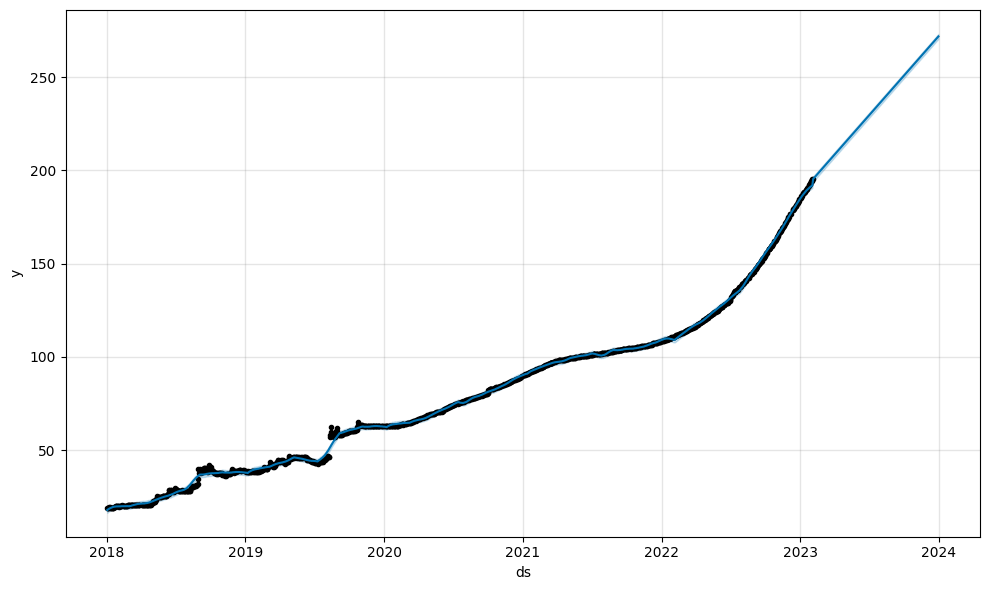

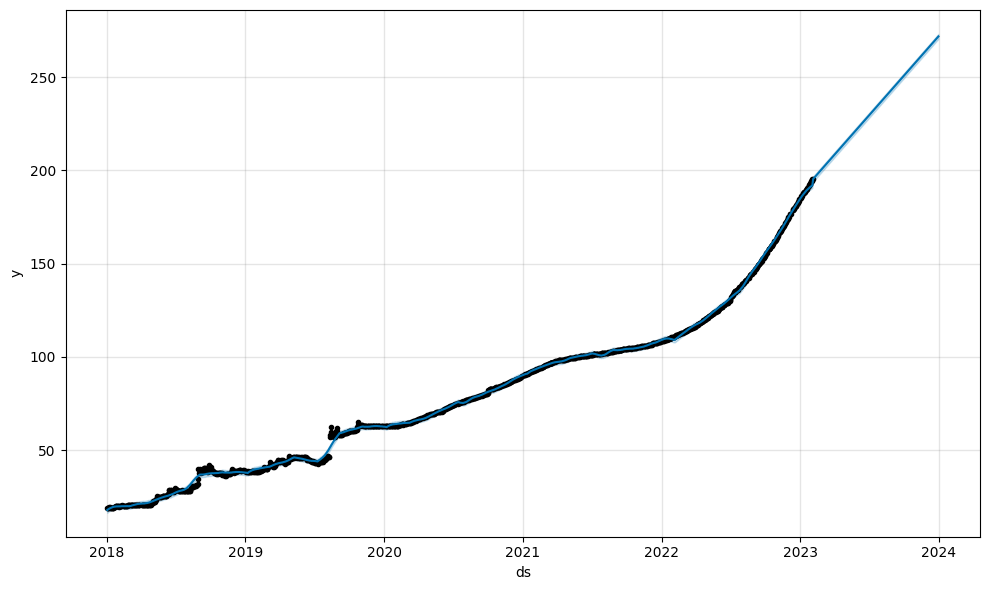

In [51]:
prophet_model.plot(pred)

In [52]:
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='y')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [53]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:57 - cmdstanpy - INFO - Chain [1] done processing


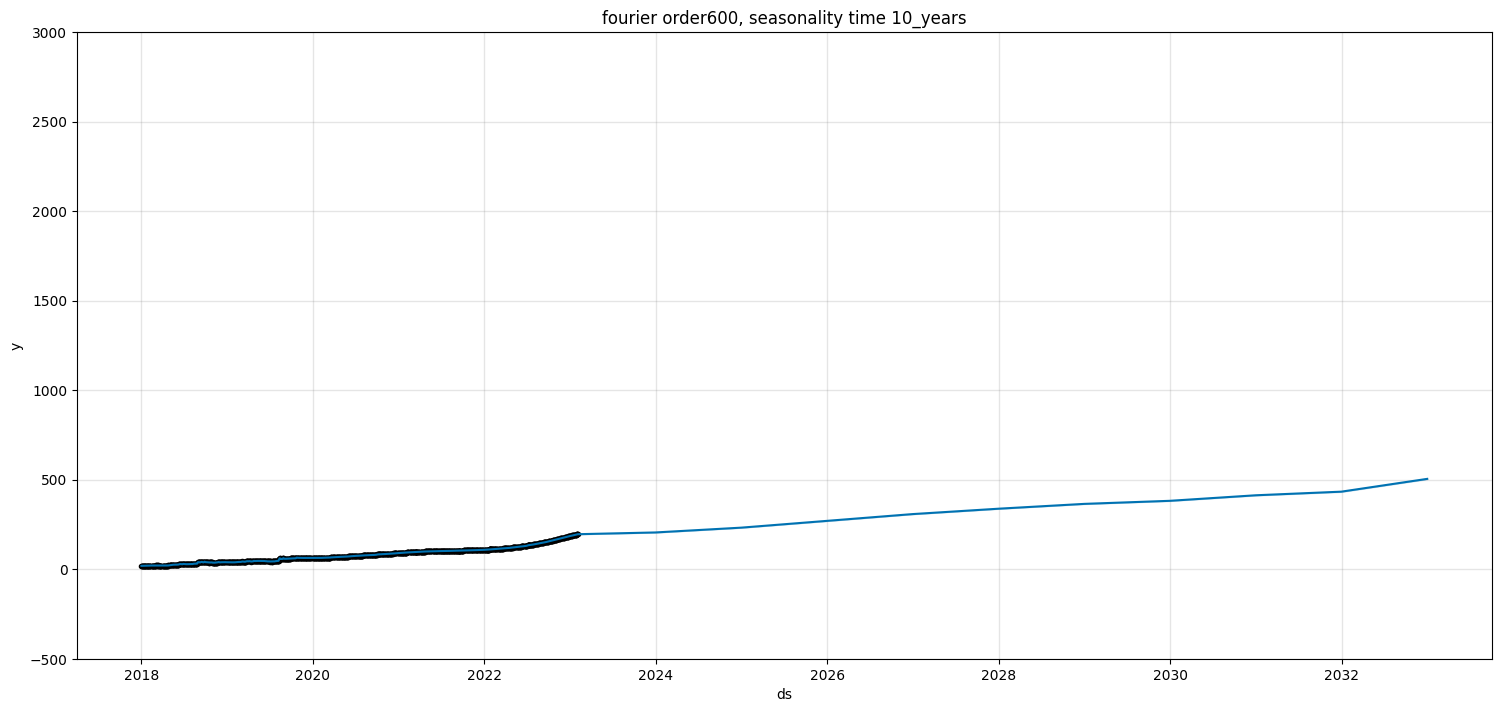

Total Execution Time 43.4365770816803 seconds


In [54]:
import time

training_set = df
validation_set = df 

ten_years = fb_prophet_function(data=training_set, future_years=10, seasonality_name='10_years', seasonality_val=365*10, seasonality_fourier=600,seasonality_mode='additive')

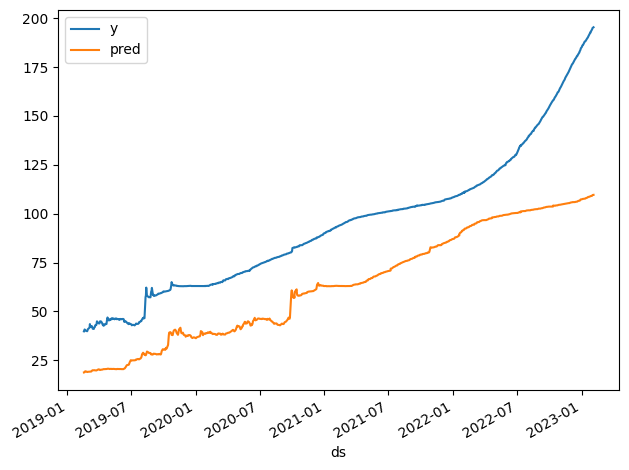

In [55]:
plot_valid(validation_set, 1000, ten_years)

In [56]:
pred = pred[['ds', 'yhat']]

pred

,ds,yhat
0,2018-01-02,17.888959
1,2018-01-03,18.015361
2,2018-01-04,18.205777
3,2018-01-05,18.338336
4,2018-01-08,18.667709
...,...,...
1234,2023-01-31,191.672496
1235,2023-02-01,191.812493
1236,2023-02-02,192.019471
1237,2023-02-04,195.395776


In [57]:
validation_set = validation_set[['ds', 'y']]

validation_set

,ds,y
1273,2018-01-02,18.76
1272,2018-01-03,18.78
1271,2018-01-04,18.96
1270,2018-01-05,19.26
1269,2018-01-08,19.34
...,...,...
3,2023-01-30,194.07
2,2023-01-31,194.36
1,2023-02-01,194.95
0,2023-02-02,195.14


In [58]:
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred

,ds,yhat
0,2018-01-02,17.888959
1,2018-01-03,18.015361
2,2018-01-04,18.205777
3,2018-01-05,18.338336
4,2018-01-08,18.667709
...,...,...
1233,2023-01-30,191.471623
1234,2023-01-31,191.672496
1235,2023-02-01,191.812493
1236,2023-02-02,192.019471


In [59]:
merged1 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged1[['ds', 'y']]
pred_ds_yhat = merged1[['ds', 'yhat']]


In [60]:
validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())

C:\Users\rodri\AppData\Local\Temp\ipykernel_21316\2616818827.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_21316\2616818827.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)

C:\Users\rodri\AppData\Local\Temp\ipykernel_21316\476390056.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_21316\476390056.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse1 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse1 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae1)
print("Mean Squared Error: ", mse1)
print("Root Mean Squared Error: ", rmse1)


Mean Absolute Error:  0.3654620976937534
Mean Squared Error:  0.5751657587516772
Root Mean Squared Error:  0.7583968346134345


In [63]:
df = df[df['ds'] >= '2021-01-01']

df

,index,ds,Compra,y
545,546,2021-01-04,84.22,90.22
544,545,2021-01-05,84.55,90.55
543,544,2021-01-06,84.55,90.55
542,543,2021-01-07,84.68,90.68
541,542,2021-01-08,84.79,90.79
...,...,...,...,...
3,4,2023-01-30,185.07,194.07
2,3,2023-01-31,185.36,194.36
1,2,2023-02-01,185.95,194.95
0,1,2023-02-02,186.14,195.14


18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:59:42 - cmdstanpy - INFO - Chain [1] done processing


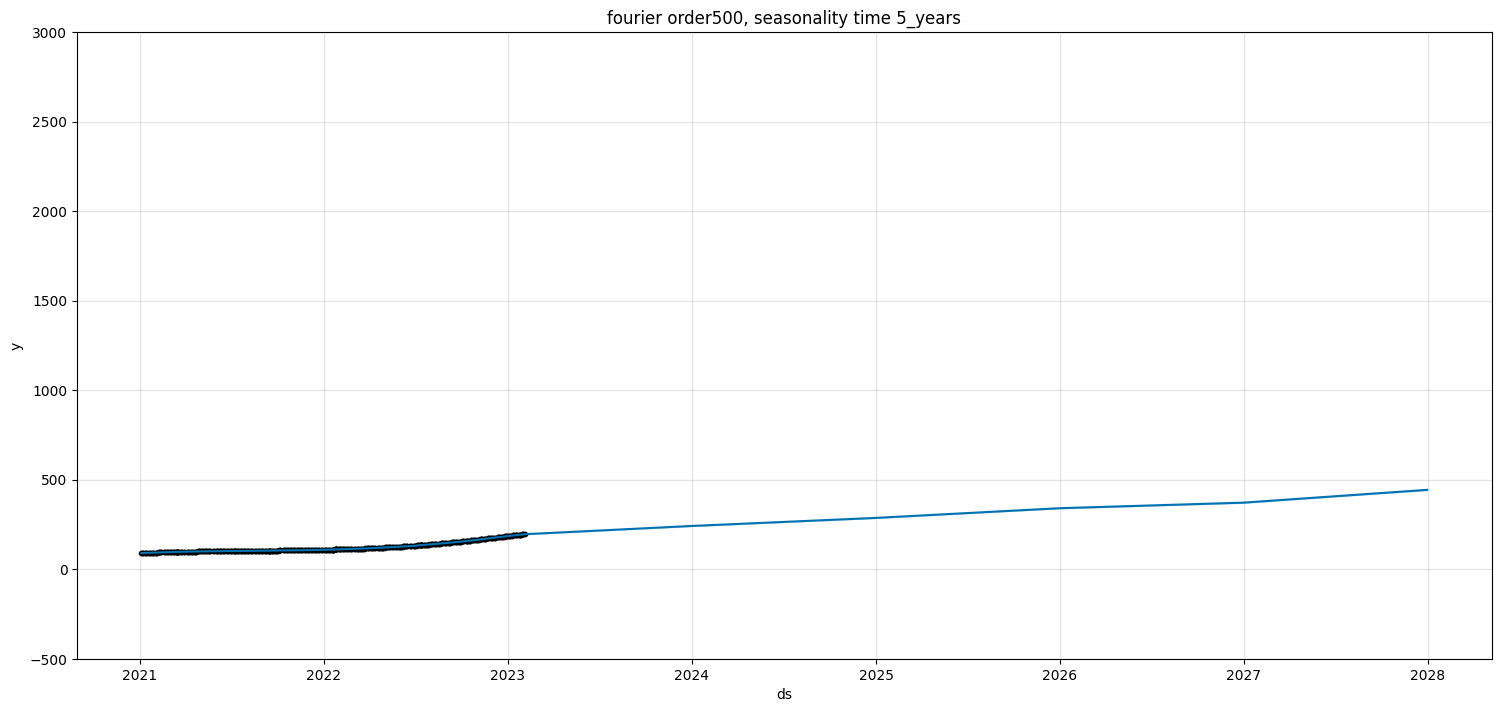

Total Execution Time 43.14849877357483 seconds


In [64]:
training_set = df
validation_set = df

five_years_model = fb_prophet_function(data=training_set, future_years=5, seasonality_name='5_years', seasonality_val=365*5, seasonality_fourier=500,seasonality_mode='additive')

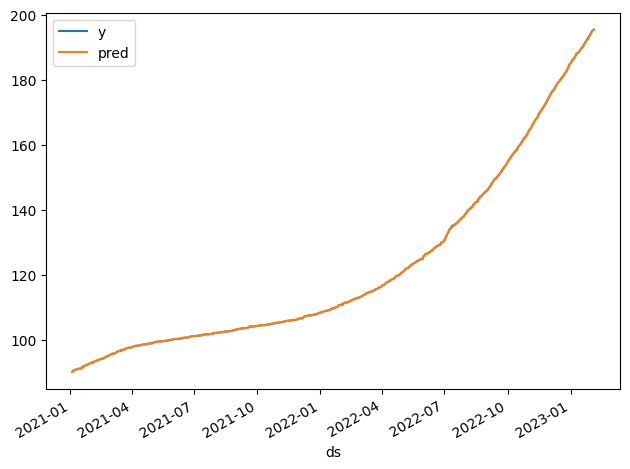

In [65]:
plot_valid(validation_set, 1000, five_years_model)

In [66]:
from sklearn.metrics import mean_squared_error

pred = pred[['ds', 'yhat']]

pred
validation_set = validation_set[['ds', 'y']]

validation_set
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred
merged2 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged2[['ds', 'y']]
pred_ds_yhat = merged2[['ds', 'yhat']]

validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)
import math

mae2 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse2 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse2 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae2)
print("Mean Squared Error: ", mse2)
print("Root Mean Squared Error: ", rmse2)


Mean Absolute Error:  0.28001055863226904
Mean Squared Error:  0.2692916722171561
Root Mean Squared Error:  0.5189332059303549


C:\Users\rodri\AppData\Local\Temp\ipykernel_21316\3875005836.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_21316\3875005836.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_21316\3875005836.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [67]:
from prophet import Prophet

five_years_model = Prophet(seasonality_mode='additive', seasonality_prior_scale=1, 
                         yearly_seasonality=True, weekly_seasonality=False, 
                         daily_seasonality=False)


In [68]:
five_years_model.add_seasonality(name='1_years', period=365*1, fourier_order=100)

In [69]:
import datetime

today = datetime.datetime.now()
next_month = today + datetime.timedelta(days=90)
start_date = today.strftime("%Y-%m-%d")
end_date = next_month.strftime("%Y-%m-%d")
date_range = pd.date_range(start_date, end_date)
next_month = pd.DataFrame({"ds": date_range})


In [70]:
five_years_model.fit(training_set)

prediction = five_years_model.predict(next_month)

18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
values = prediction['yhat']

values_new = pd.DataFrame(values)

values_new = values_new.rename(columns={'yhat':'Values'})

values_new

,Values
0,195.636489
1,196.106750
2,196.483917
3,196.754046
4,197.017515
...,...
86,220.761117
87,221.103068
88,221.498833
89,221.894495


In [72]:
# import the datetime library
import datetime

# define the start date (today + 1) and the number of days in the range
start_date = datetime.datetime.today() + datetime.timedelta(days=1)
num_days = len(values_new.index)

# create the date range
date_range = [start_date.date() + datetime.timedelta(days=i) for i in range(num_days)]

# set the index of the dataframe to the date range
values_new.index = date_range

values_new


,Values
2023-02-05,195.636489
2023-02-06,196.106750
2023-02-07,196.483917
2023-02-08,196.754046
2023-02-09,197.017515
...,...
2023-05-02,220.761117
2023-05-03,221.103068
2023-05-04,221.498833
2023-05-05,221.894495


In [73]:
values_new.to_excel("data/xlsx/values_newOf.xlsx")

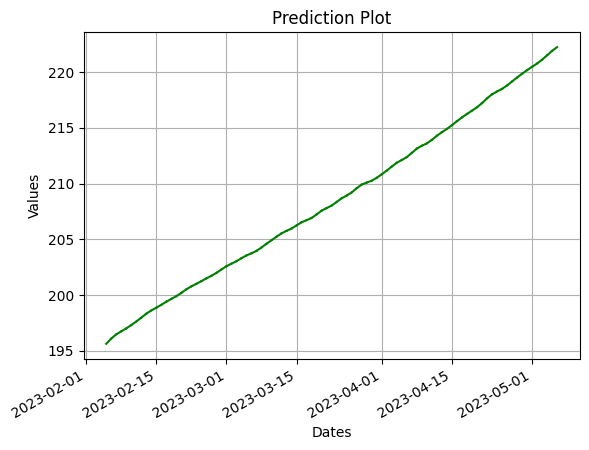

In [74]:
x = values_new.index
y = values_new['Values']
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'g'
    else:
        color = 'r'
    plt.plot(x[i-1:i+1], y[i-1:i+1], color=color)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title("Prediction Plot")
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()


In [75]:
import plotly.graph_objs as go
import plotly.offline as pyo

data = []
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'green'
    else:
        color = 'red'
    trace = go.Scatter(x=x[i-1:i+1], y=y[i-1:i+1], mode='lines', line=dict(color=color, width=1), showlegend=False)
    data.append(trace)

layout = go.Layout(title='Prediccion Dolar Oficial', xaxis=dict(title='Fecha'), yaxis=dict(title='Valores'))
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [76]:
with open('data/html/Predicciones/Pred_DolarOF.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))